# Accelerometer analysis
---

This notebook 

### Load source code

In [1]:
include(joinpath("../src", "ActStatData.jl"))
include(joinpath("../src", "ActPlotData.jl"))

Main.ActPlotData

### Local module

In [2]:
module mWavelet

function mThreshSoft(WaveletData::Array{Array{Float64,1},1}, myThresh::Float64)
    numLevel = length(WaveletData)
    for i in 2:numLevel
        myWaveCoefs = WaveletData[i]
        newCoefs = map(x ->abs(0.5*(sign(abs(x)-myThresh)^sign(abs(x)-myThresh)+1)), myWaveCoefs).*
                    sign.(myWaveCoefs).*(abs.(myWaveCoefs)-myThresh);
        WaveletData[i] = newCoefs;
    end
    return WaveletData
end


function mThreshHard(WaveletData::Array{Array{Float64,1},1}, myThresh::Float64)
    numLevel = length(WaveletData)
    for i in 2:numLevel
        myWaveCoefs = WaveletData[i]
        newCoefs = map(x ->abs(0.5*(sign(abs(x)-myThresh)^sign(abs(x)-myThresh)+1)), myWaveCoefs).*myWaveCoefs;
        WaveletData[i] = newCoefs;
    end
    return WaveletData
end

function mThreshMax(WaveletData::Array{Array{Float64,1},1}, myThresh::Float64)
    numLevel = length(WaveletData)
    for i in 2:numLevel
        myWaveCoefs = WaveletData[i]
        newCoefs = 0 .*myWaveCoefs;
        WaveletData[i] = newCoefs;
    end
    return WaveletData
end

end

Main.mWavelet

### Import libraries

In [3]:
using PyCall
# pygui(:tk)
using PyPlot
PyPlot.svg(true)
using DataFrames, Dates, StatsBase
using .ActPlotData

### Extract data

In [4]:
# List of visit directories
listDir = ["../data/Baseline Visit Data/";
           "../data/32 Week Gestation Data/";
           "../data/6 Week PP Data/";
           "../data/6 Months PP Data/"]

myDir = listDir[1];
# Get the data list files from the directory myDir
(myData, myHeader) = ActStatData.filesNoNaN(myDir);

There is no missing (i.e. NA) data log in the following directory:
../data/Baseline Visit Data/


In [5]:
# Get any file and show columns of the data frame structure
df = ActStatData.readActivity(joinpath(myDir,myData[2]));
describe(df)

7×7 DataFrame
 Row │ variable           mean         min                  median             ⋯
     │ Symbol             Union…       Any                  Any                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Day                43.0563      1                    43.0               ⋯
   2 │ ElapsedSeconds     3.62721e6    180                  3.62721e6
   3 │ DateTime                        2017-03-09T13:50:00  2017-04-20T13:20:3
   4 │ ActivityCounts     19.1926      0                    0.0
   5 │ Steps              0.866727     0                    0.0                ⋯
   6 │ EnergyExpenditure  0.000706258  0.0                  0.0
   7 │ ActivityIntensity  1.05232      1                    1.0
                                                               4 columns omitted

In [6]:
# Select the column of the data frame to be processed and displayed
colNum = 4;
(myAvg, myMed, myVar, myCor, myMat) = ActStatData.getStatAct(myDir,myData, colNum);
# myAvg is the colNum data average over all subjects over one visit
# myVar is the colNum data variance over all subjects over one visit
# myCor is the colNum data correlation over all subjects over one visit
# myMat is the matrix containing each  subjects colNum data average over one visit

In [23]:
# Select the column of the data frame to compare with Activity Count
colNum = 6;
(myAvg2, myMed2, myVar2, myCor2, myMat2) = ActStatData.getStatAct(myDir,myData, colNum);
# myAvg is the colNum data average over all subjects over one visit
# myVar is the colNum data variance over all subjects over one visit
# myCor is the colNum data correlation over all subjects over one visit
# myMat is the matrix containing each  subjects colNum data average over one visit

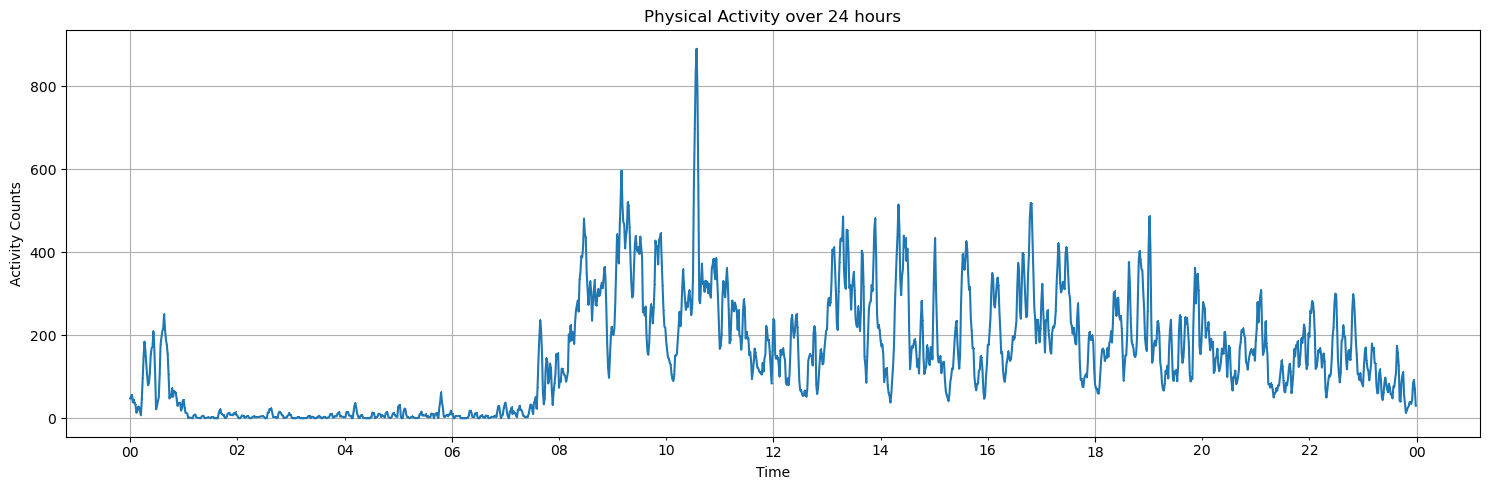

In [63]:
#fig0 = figure("Physical Activity",figsize=(15,5))
# ActPlotData.plotAct(myAvg, "Physical Activity over 24 hours")

IDnum = 22;
 ActPlotData.plotAct(hcat(myMat[:,IDnum]), "Physical Activity over 24 hours")

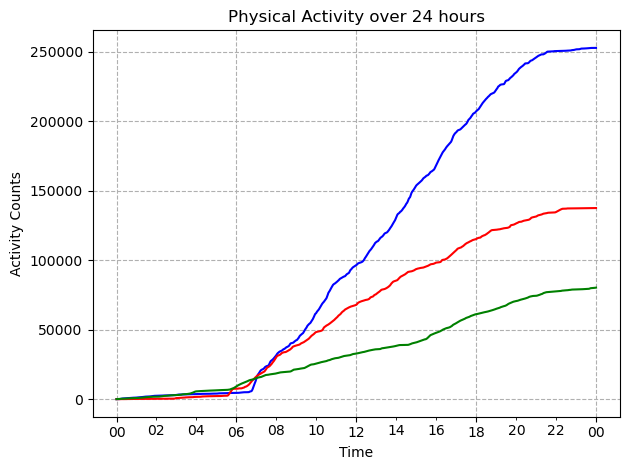

In [43]:
ActPlotData.plotTriAct(accumulate(+, hcat(myMat[:,IDnum])), accumulate(+, hcat(myMat[:,3])),accumulate(+, hcat(myMat[:,10])), "Physical Activity over 24 hours")

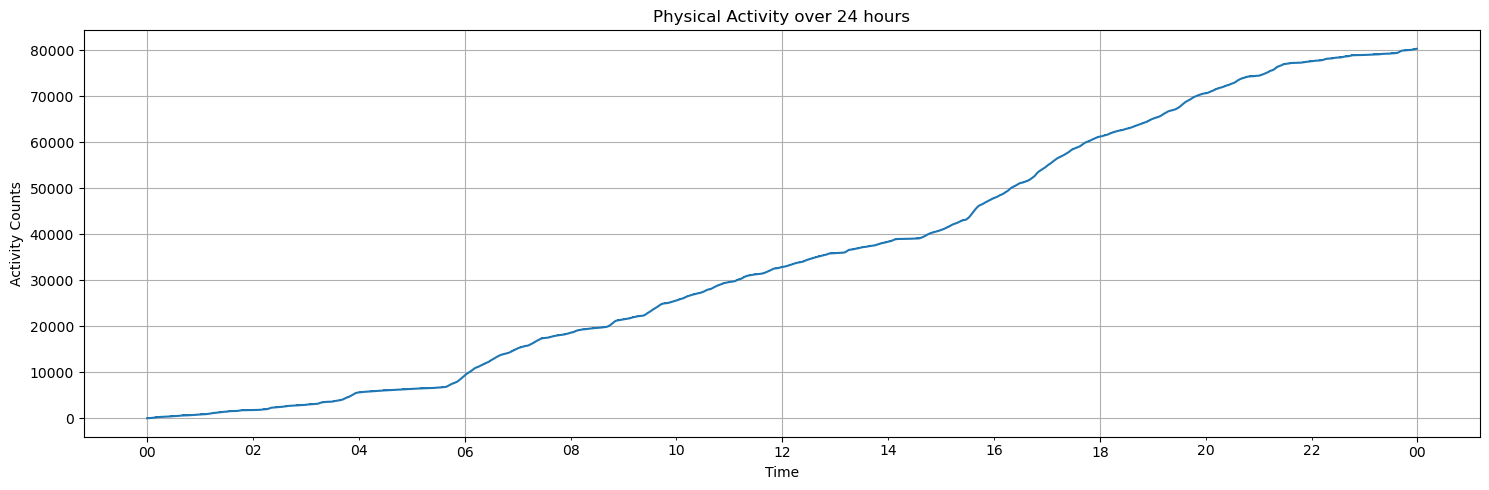

In [44]:
ActPlotData.plotAct(accumulate(+, hcat(myMat[:,10])), "Physical Activity over 24 hours")

In [64]:
#############
#  Wavelet  #
#############


# Using Python libraries from Julia
@pyimport pylab 
@pyimport pywt

import .mWavelet
mydb8 = pywt.Wavelet("db8");

noisy_coefs = pywt.wavedec(myMat[:, IDnum], mydb8, level=6, mode="constant");

mySigma = mad(noisy_coefs[7], normalize = true)
uthresh = mySigma* sqrt(2*log(length(noisy_coefs[7])))

denoised = mWavelet.mThreshMax(noisy_coefs, uthresh);

signal = pywt.waverec(denoised, mydb8, mode="constant");


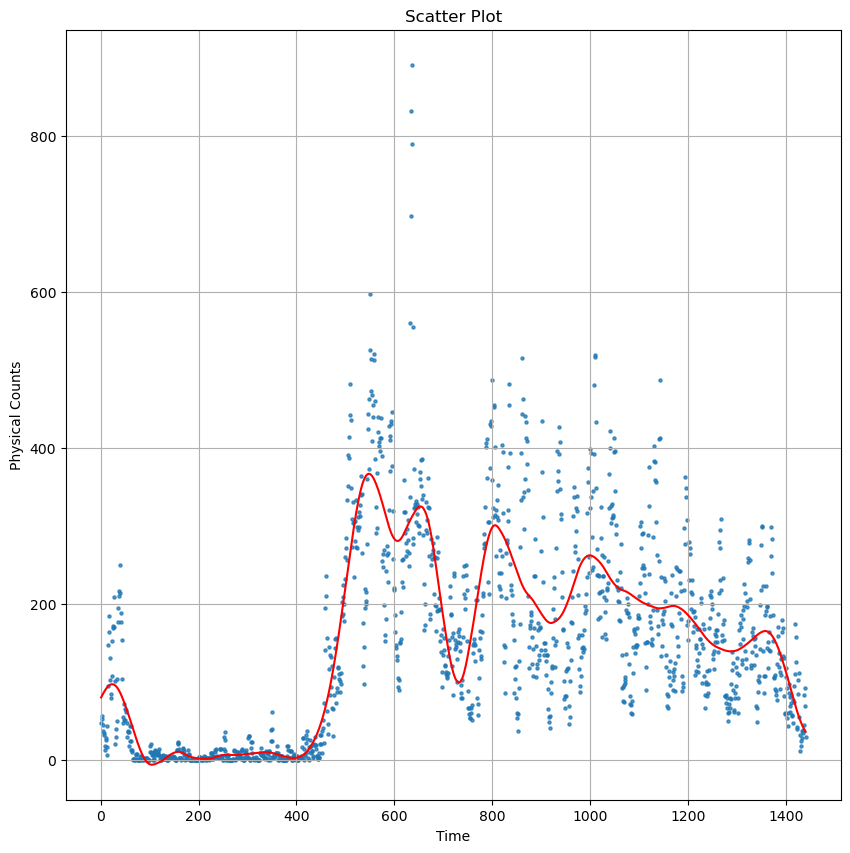

In [65]:
##################
#  Scatter Plot  #
##################
ioff() # Interactive plotting OFF, necessary for inline plotting in IJulia

#################
#  Create Data  #
#################
x = collect(1:1:1440)
y = hcat(myMat[:,IDnum])
areas = 5;


fig = figure("pyplot_scatterplot",figsize=(10,10))
ax = PyPlot.axes()
scatter(x,y,s=areas,alpha=0.75);plot(collect(1:1440), signal,color = "r");

title("Scatter Plot")
xlabel("Time")
ylabel("Physical Counts")
grid("on")
#gcf() # Needed for IJulia to plot inline

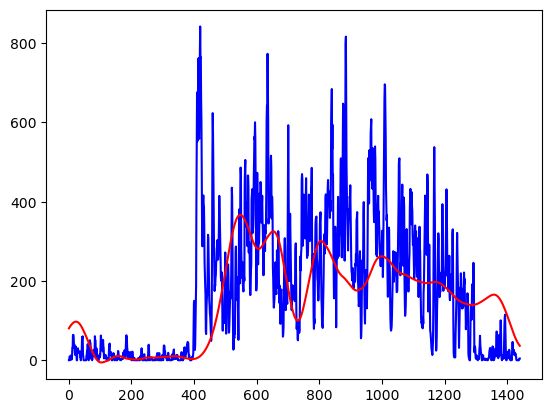

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005BED79D0>

In [67]:
noisy_coefs = pywt.wavedec(myMat[:, IDnum], mydb8, level=6, mode="constant");

mySigma = mad(noisy_coefs[7], normalize = true)
uthresh = mySigma* sqrt(2*log(length(noisy_coefs[7])))

denoised = mWavelet.mThreshMax(noisy_coefs, uthresh);

signal = pywt.waverec(denoised, mydb8, mode="constant");
plot(collect(1:1440), myMat[:, 21],color = "b");plot(collect(1:1440), signal,color = "r")

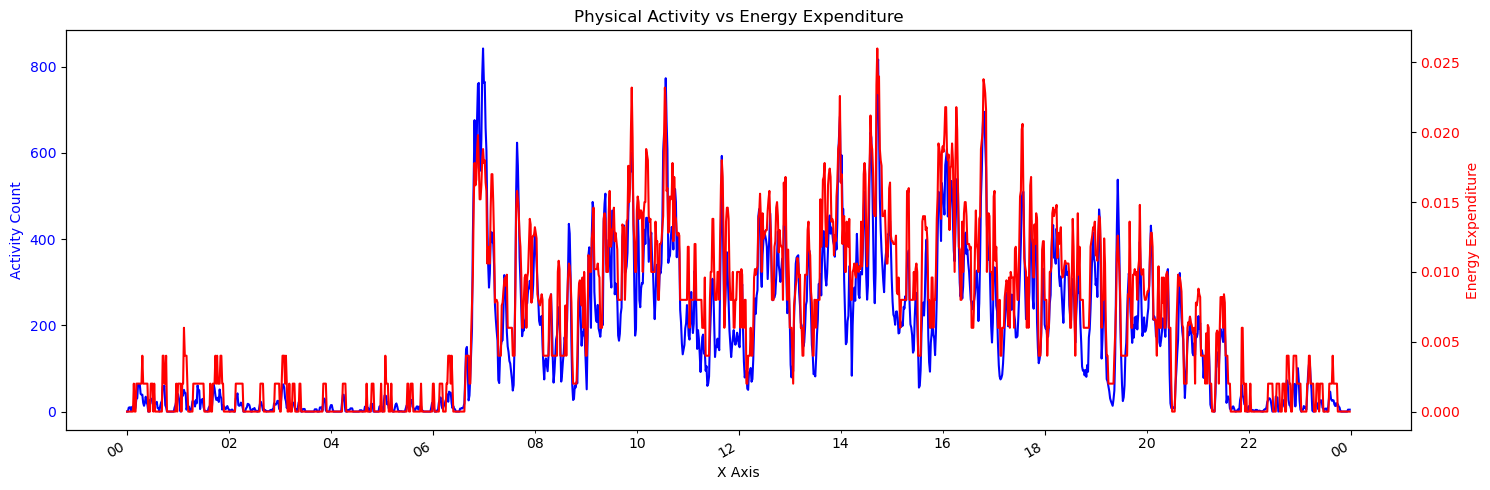

In [72]:
ActPlotData.dualPlotAct(hcat(myMat[:,21]), hcat(myMat2[:,21]), "Physical Activity vs Energy Expenditure")


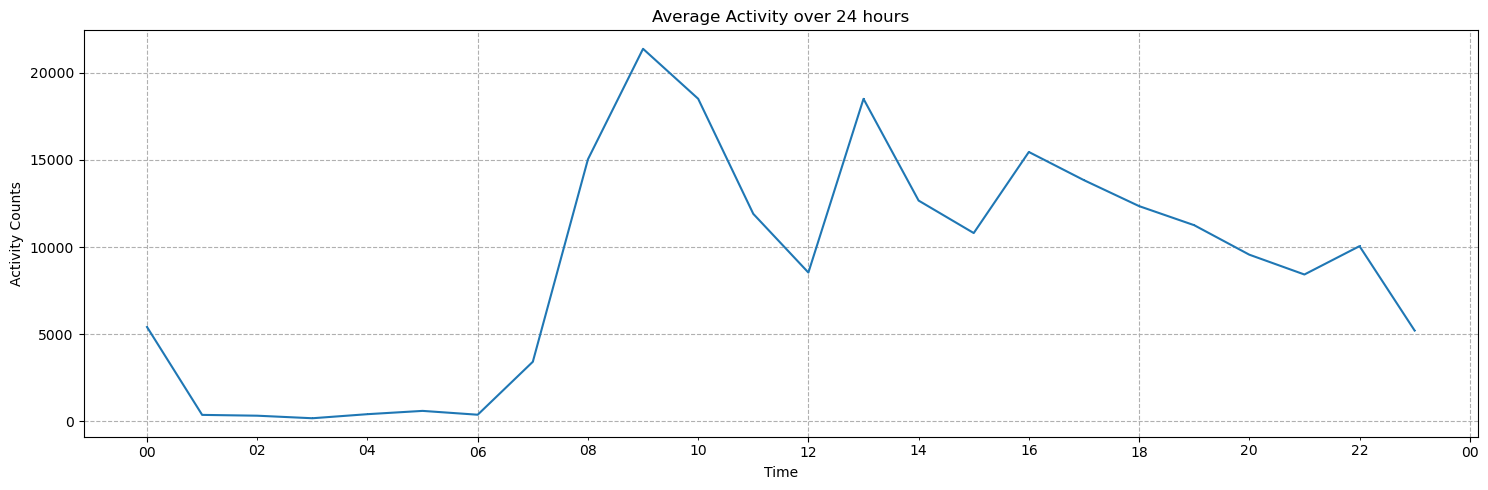

In [102]:
#fig10 = figure("Physical Activity",figsize=(15,5))
ActPlotData.smoothPlotAct(myMat[:,IDnum],60)

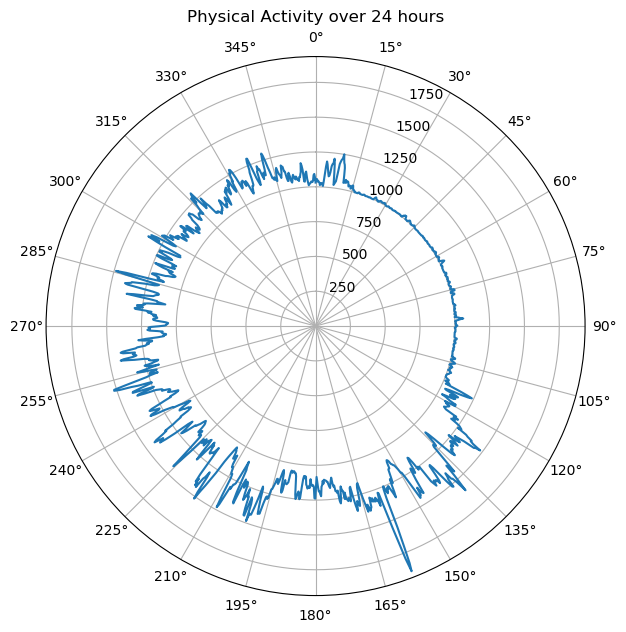

In [112]:
#figC = figure("Physical Activity Cir",figsize=(5,5))
ActPlotData.plotCircAct(hcat(myMat[:,IDnum]..+1000), "Physical Activity over 24 hours") # 15 dregree corresponds to 1 hour

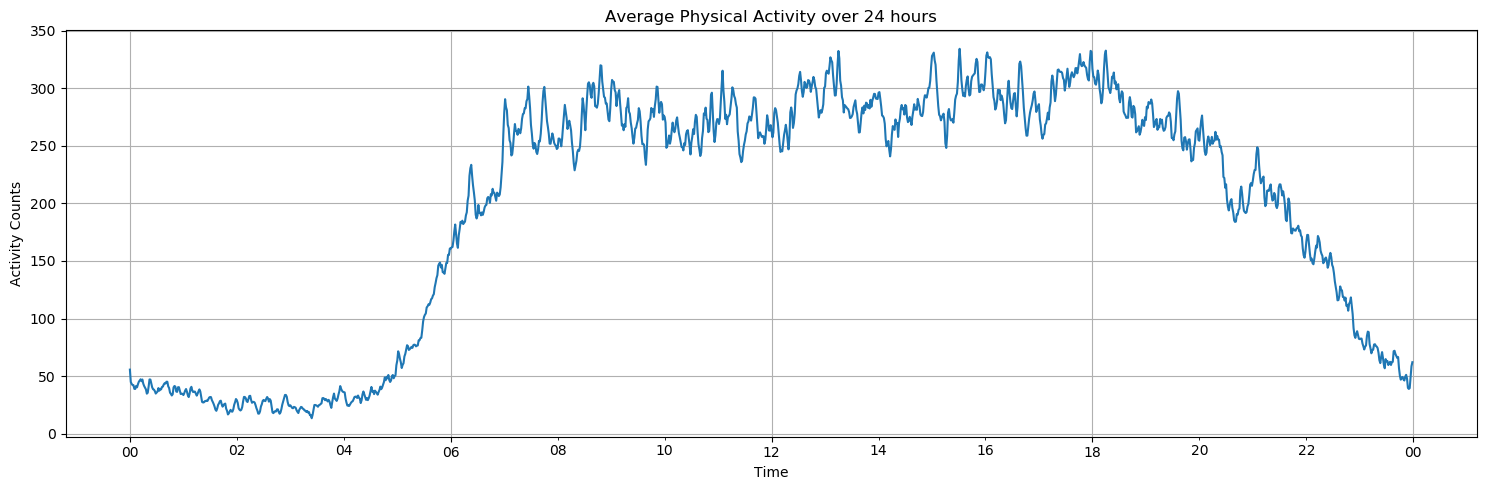

In [38]:
fig1 = figure("Average Activity",figsize=(15,5))
ActPlotData.plotAct(myAvg, "Average Physical Activity over 24 hours")

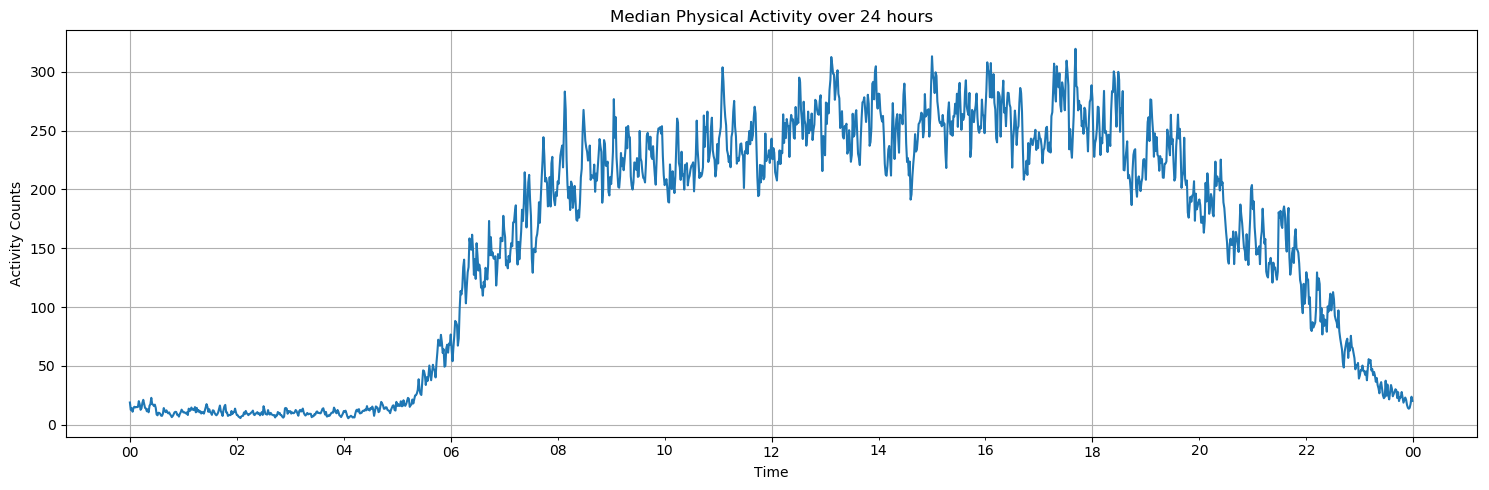

In [37]:
fig2 = figure("Median Activity",figsize=(15,5))
ActPlotData.plotAct(myMed, "Median Physical Activity over 24 hours")

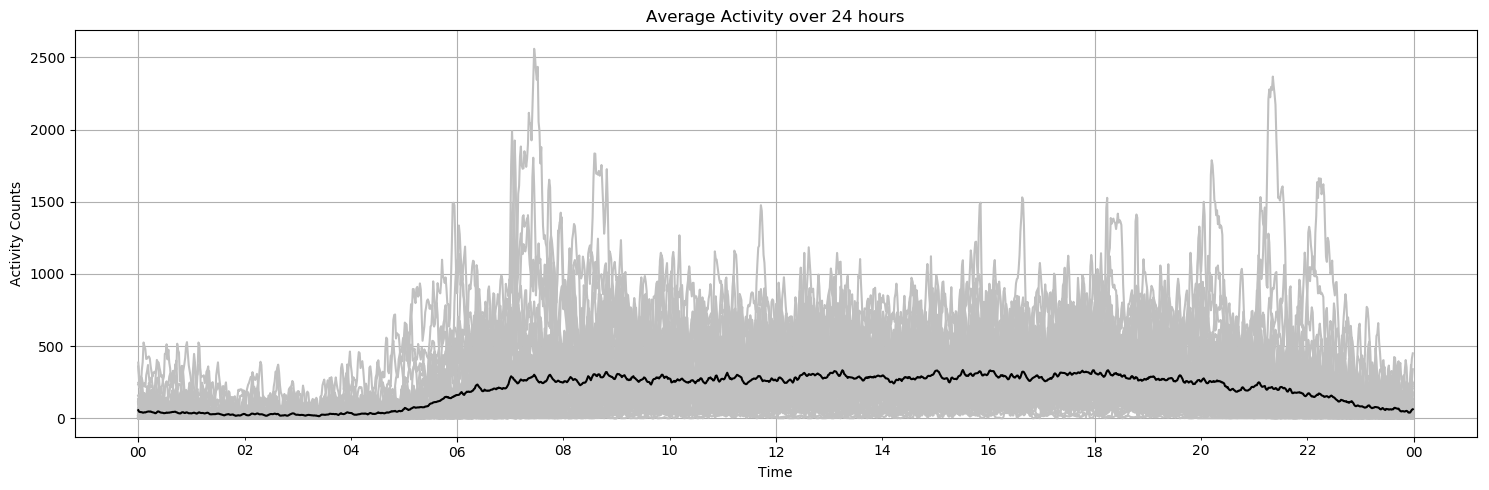

In [16]:
fig3 = figure("Average Activity",figsize=(15,5))
ActPlotData.plotFullAct(myMat)

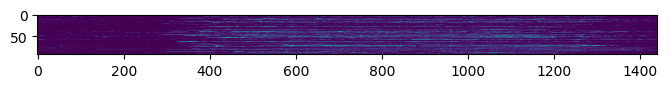

PyObject <matplotlib.image.AxesImage object at 0x7f478f7f5cd0>

In [10]:
figHeatMap = figure("HeatMap", figsize=(8,8))
imshow(myMat') #cmap= "jet", interpolation="bi", vmin=-1, vmax=1)
#colorbar()

In [11]:
size(myMat)

(1440, 92)

In [7]:
newMat = repeat(myMat', inner =(20,1), outer=(1,1));
figHeatMap = figure("HeatMap", figsize=(8,8))
PyPlot.pcolormesh(log.(newMat.+1), cmap = "jet") #imshow(log.(newMat+1), cmap= "jet")
colorbar()

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000001625100>

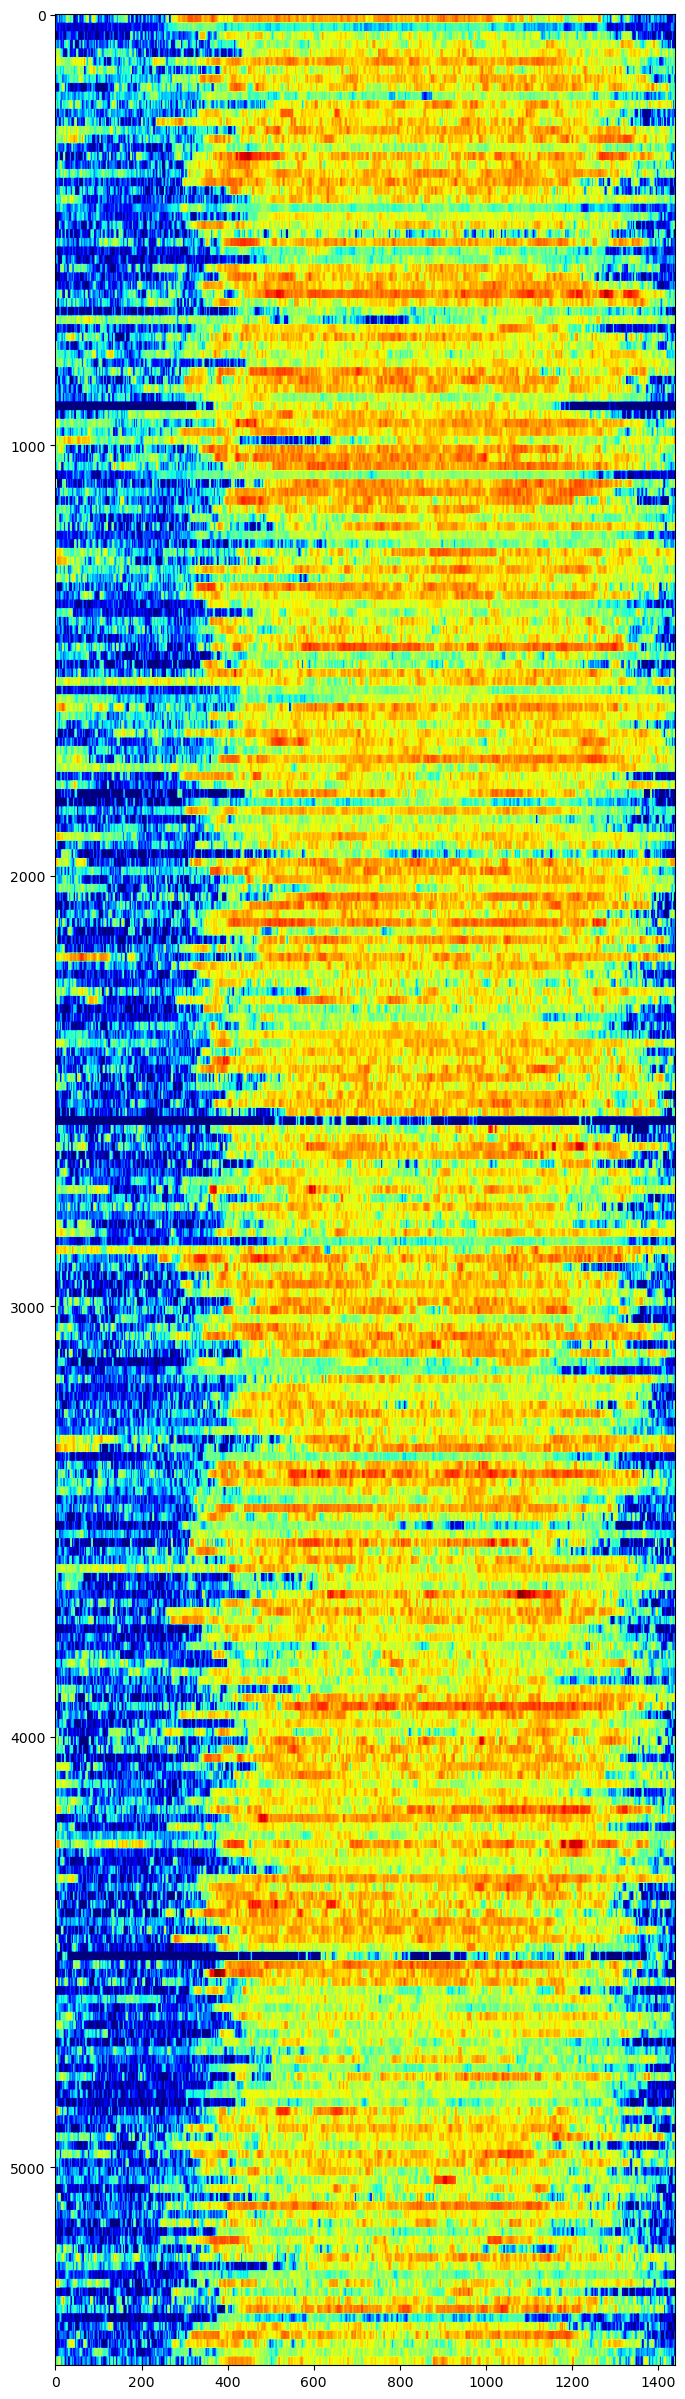

PyObject <matplotlib.image.AxesImage object at 0x00000001E87F94F0>

In [16]:
figure("HeatMap", figsize=(8,32))
imshow(log.(newMat.+1), cmap= "jet")

In [17]:

x = range(0, 1440, 1440);
y = range(0,1840,1840);

xgrid = repeat(x',1440,1);
ygrid = repeat(y,1,1840);

z = newMat;

In [ ]:


subplot(212)
ax = fig[:add_subplot](2,1,2)
cp = ax[:contour](xgrid, ygrid, z, colors="black", linewidth=2.0)
ax[:clabel](cp, inline=1, fontsize=10)
xlabel("X")
ylabel("Y")
title("Contour Plot")
tight_layout()
gcf() # Needed for IJulia to plot inline

In [ ]:
fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](2,1,1, projection = "3d")
ax[:plot_surface](xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.8, linewidth=0.25)
xlabel("X")
ylabel("Y")
title("Surface Plot")

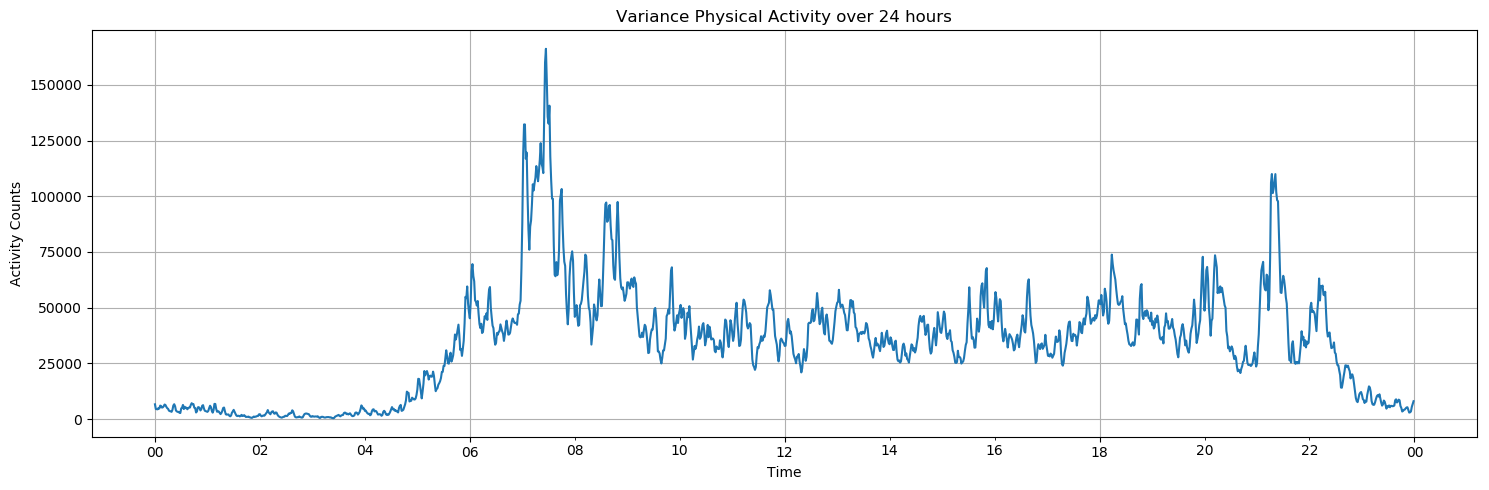

In [55]:
fig4 = figure("Variance Activity",figsize=(15,5))
ActPlotData.plotAct(myVar, "Variance Physical Activity over 24 hours")

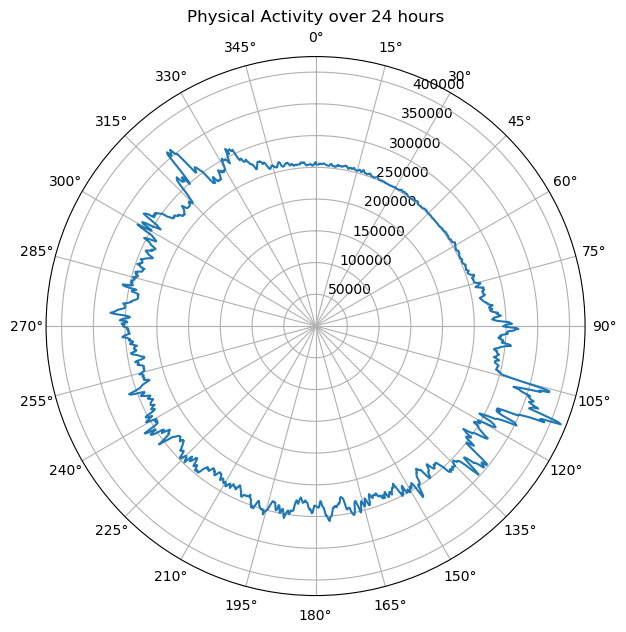

In [56]:
ActPlotData.plotCircAct(myVar.+250000, "Physical Activity over 24 hours") # 15 dregree corresponds to 1 hour

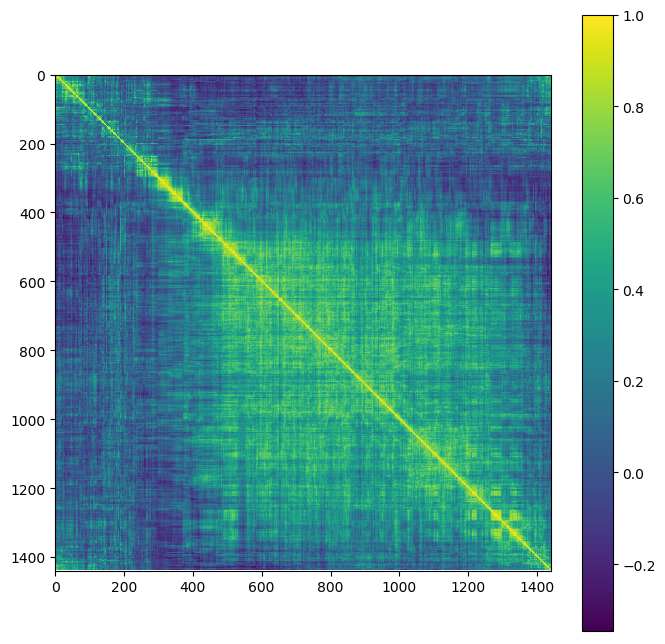

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6ab5041e90>

In [57]:
fig5 = figure("Correlation", figsize=(8,8))
imshow(myCor) #cmap= "jet", interpolation="bi", vmin=-1, vmax=1)
colorbar()